Pada Project kali ini kita akan menggunakan twitter sebagai media untuk mencari data yang kita butuhkan.
Dikarenakan twitter merupakan salah satu media yang dimana ada ketika suatu topik viral, maka netizen/masyarakat
akan memberikan memberikan tanggapan mengenai topik atau isu tersebut.nah tanggapan dari netizen inilah yang akan kita
analisa dengan menggunakan metode sentiment analysis

## Import library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json, tweepy, requests, re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
from string import punctuation
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
nltk.download('popular')
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from collections import Counter


     |████████████████████████████████| 209 kB 16.3 MB/s 
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | 

## menghubungkan python dengan server twitter

In [ ]:

with open("token.json") as f:
  tokens = json.load(f)
bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

tokens.keys()

dict_keys(['bearer_token', 'api_key', 'api_key_secret', 'access_token', 'access_token_secret'])

In [ ]:
auth = tweepy.OAuthHandler(api_key,api_key_secret)
auth.set_access_token(access_token,access_token_secret) 
api = tweepy.API(auth,wait_on_rate_limit=True)

In [ ]:
# mengambil fitur-fitur penting dari twitter
def search_tweet(query,dari,sampai):
    tweets = tweepy.Cursor(api.search,q=query,tweet_mode="extended",since=dari,until=sampai,lang="id").items(1000)
    message,retweet_count,retweet,created_at,user_name,user_id=[],[],[],[],[],[]
    count = 0
    for tweet in tweets:
        count=count+1
        if hasattr(tweet, 'retweeted_status'):
            message.append(tweet.retweeted_status.full_text)
            retweet_count.append(tweet.retweet_count)
            retweet.append(tweet.retweeted_status.user.screen_name)
            created_at.append(tweet.created_at)
            user_name.append(tweet.user.screen_name)
            user_id.append(tweet.user.id)
        else:
            message.append(tweet.full_text)
            retweet_count.append(tweet.retweet_count)
            retweet.append(print(''))
            created_at.append(tweet.created_at)
            user_name.append(tweet.user.screen_name)
            user_id.append(tweet.user.id)
    return [message,retweet_count,retweet,created_at,user_name,user_id]



In [ ]:
x=search_tweet(query="corona",dari="2022-01-23",sampai="2022-01-24")
# make dataframe
df=pd.DataFrame(x)
df = df.transpose()
df.columns = ['tweets','retweet_count','retweet_from','created_at','username','user_id']
df = df.sort_values(['created_at'], ascending=[0])

In [ ]:
df

,tweets,retweet_count,retweet_from,created_at,username,user_id
0,@republikaonline Bulan2 ini memang musim panca...,0,None,2022-01-23 23:59:51,cakmas12345,1176063840661848064
1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,None,2022-01-23 23:57:45,cakmas12345,1176063840661848064
2,Plandemi bagian pemicu proyek politik https://...,0,None,2022-01-23 23:54:33,MohSantos2,1333393223620853760
3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23 23:50:21,piyaaapiyoo,510151538
4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23 23:46:07,CSAetudiant,749396736540413952
...,...,...,...,...,...,...
995,@Dhivi_SK Unga Name La Oru Letter sympol IRuKk...,0,None,2022-01-23 06:33:16,Corona_Anbe,1388311204435689479
996,Lagu Corona versi Cepot (Sunda) https://t.co/9...,8,arwidodo,2022-01-23 06:33:05,iDXW33D,2334717912
997,sejak awal corona anjir https://t.co/ayWnAcocHN,0,None,2022-01-23 06:32:20,gagalbackstreet,1296098300769079297
998,Dulu sebelum corona Masuk Dia paling keras mel...,257,dwiki___411,2022-01-23 06:32:03,mikahakim3,1027940567907352576


In [ ]:
y=search_tweet(query="corona",dari="2022-01-24",sampai="2022-01-25")
# make dataframe
df1=pd.DataFrame(y)
df1=df1.transpose()
df1.columns = ['tweets','retweet_count','retweet_from','created_at','username','user_id']
df1 = df1.sort_values(['created_at'], ascending=[0])

In [ ]:
df1

,tweets,retweet_count,retweet_from,created_at,username,user_id
0,Kepercayaan partai komunis China dlm menghadap...,12,jacktanggo_34,2022-01-24 23:59:53,IkaJatnika,919102046598447105
1,Ini di desa aku ga ada yang kena corona apa ya...,0,None,2022-01-24 23:59:36,yolavebiola,620744046
2,"Terungkap, 999 Makam di TPU Cikadut Bandung Ha...",492,RaisaTjokrodnta,2022-01-24 23:56:13,SantaPradana,277434571
3,Kepercayaan partai komunis China dlm menghadap...,12,jacktanggo_34,2022-01-24 23:56:02,7lRiv3rSid3,1321963089827299328
4,Kepercayaan partai komunis China dlm menghadap...,12,jacktanggo_34,2022-01-24 23:55:55,F85h1p2lI81f633,1139242184694104065
...,...,...,...,...,...,...
995,@hary_rezpector @tempodotco Iya covidnya masih...,0,None,2022-01-24 10:09:32,BaimCikadap,1299383748258013186
996,LANGSUNG DINO AJUR 4/7 NANIWA KENA CORONA\nLIN...,0,None,2022-01-24 10:09:31,IvaMardiani,320027494
997,@JavedMustafa_ Online exam ho ya to promote kr...,1,Ratnesh97196296,2022-01-24 10:09:28,Ratnesh97196296,1479830418006294532
998,@JavedMustafa_ Online exam ho ya to promote kr...,1,None,2022-01-24 10:08:46,Ratnesh97196296,1479830418006294532


In [ ]:
z=search_tweet(query="corona",dari="2022-01-25",sampai="2022-01-26")
# make dataframe
df2=pd.DataFrame(z)
df2=df2.transpose()
df2.columns = ['tweets','retweet_count','retweet_from','created_at','username','user_id']
df2 = df2.sort_values(['created_at'], ascending=[0])

In [ ]:
xx=search_tweet(query="corona",dari="2022-01-26",sampai="2022-01-27")
# make dataframe
df3=pd.DataFrame(xx)
df3=df3.transpose()
df3.columns = ['tweets','retweet_count','retweet_from','created_at','username','user_id']
df3 = df3.sort_values(['created_at'], ascending=[0])

In [ ]:
#menggabungkan keempat dataframe jadi satu
df_new=pd.concat([df,df1,df2,df3])
df_new.to_csv('corona.csv')

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tweets         4000 non-null   object        
 1   retweet_count  4000 non-null   object        
 2   retweet_from   1398 non-null   object        
 3   created_at     4000 non-null   datetime64[ns]
 4   username       4000 non-null   object        
 5   user_id        4000 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 218.8+ KB


In [ ]:
df=pd.read_csv('corona.csv')

In [ ]:
df

,Unnamed: 0,tweets,retweet_count,retweet_from,created_at,username,user_id
0,0,@republikaonline Bulan2 ini memang musim panca...,0,NaN,2022-01-23 23:59:51,cakmas12345,1176063840661848064
1,1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,NaN,2022-01-23 23:57:45,cakmas12345,1176063840661848064
2,2,Plandemi bagian pemicu proyek politik https://...,0,NaN,2022-01-23 23:54:33,MohSantos2,1333393223620853760
3,3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23 23:50:21,piyaaapiyoo,510151538
4,4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23 23:46:07,CSAetudiant,749396736540413952
...,...,...,...,...,...,...,...
3995,995,Ni corona kapan kelarnya sih ya allah 😭,0,NaN,2022-01-26 09:14:51,tueseungday,580743878
3996,996,"Jokowi mengungkapkan, vaksinasi melindungi kit...",0,NaN,2022-01-26 09:14:39,JeremiahRachma,4583703018
3997,997,MENYIKAPI ISTRI YANG MANJA (1 menitan)\n\nUsta...,17,muhammadnuzuldz,2022-01-26 09:13:41,ReynaldiOrton,1474367792132485122
3998,998,wadaww corona semua :( cepet sembuh semuanyaa :(,0,NaN,2022-01-26 09:11:59,hitsuzn,1117117428


## Preprocessing Data

In [ ]:
#mengambil data tanggal saja dari kolom tanggal
df['created_at'] = pd.to_datetime(df['created_at']).dt.date

### Case folding, tokenizing,stopword

In [11]:
# helper function to clean tweets
def case_folding(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')
    return tweet

def tokenizing(data):
    data= word_tokenize(data)
    return data

def clear_stopwords(data):
    ind_stopword=stopwords.words("indonesian")
    data=[word for word in data if word not in ind_stopword]
    data=' '.join(data)
    return data

In [ ]:
df['clean_tweet']=df['tweets'].apply(lambda x: case_folding(x))
df['clean_tweet']=df['clean_tweet'].apply(lambda x: tokenizing(x))
df['clean_tweet']=df['clean_tweet'].apply(lambda x: clear_stopwords(x))

In [ ]:
df

,Unnamed: 0,tweets,retweet_count,retweet_from,created_at,username,user_id,clean_tweet
0,0,@republikaonline Bulan2 ini memang musim panca...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,bulan2 musim pancaroba musim penyakit gitu tum...
1,1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,musim pancaroba rawan penyakit dikaitkan coron...
2,2,Plandemi bagian pemicu proyek politik https://...,0,NaN,2022-01-23,MohSantos2,1333393223620853760,plandemi pemicu proyek politik
3,3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23,piyaaapiyoo,510151538,pemerintah mengumumkan data covid corona 205 s...
4,4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23,CSAetudiant,749396736540413952,virus corona penyebab covid ngapain aja sih pa...
...,...,...,...,...,...,...,...,...
3995,995,Ni corona kapan kelarnya sih ya allah 😭,0,NaN,2022-01-26,tueseungday,580743878,corona kelarnya sih allah
3996,996,"Jokowi mengungkapkan, vaksinasi melindungi kit...",0,NaN,2022-01-26,JeremiahRachma,4583703018,jokowi vaksinasi melindungi ancaman virus corona
3997,997,MENYIKAPI ISTRI YANG MANJA (1 menitan)\n\nUsta...,17,muhammadnuzuldz,2022-01-26,ReynaldiOrton,1474367792132485122,menyikapi istri manja menitan ustadz muhammad ...
3998,998,wadaww corona semua :( cepet sembuh semuanyaa :(,0,NaN,2022-01-26,hitsuzn,1117117428,wadaww corona cepet sembuh semuanyaa


### stemming

In [ ]:
# menghapus data duplikat
df = df.drop_duplicates('clean_tweet')
df

,Unnamed: 0,tweets,retweet_count,retweet_from,created_at,username,user_id,clean_tweet
0,0,@republikaonline Bulan2 ini memang musim panca...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,bulan2 musim pancaroba musim penyakit gitu tum...
1,1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,musim pancaroba rawan penyakit dikaitkan coron...
2,2,Plandemi bagian pemicu proyek politik https://...,0,NaN,2022-01-23,MohSantos2,1333393223620853760,plandemi pemicu proyek politik
3,3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23,piyaaapiyoo,510151538,pemerintah mengumumkan data covid corona 205 s...
4,4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23,CSAetudiant,749396736540413952,virus corona penyebab covid ngapain aja sih pa...
...,...,...,...,...,...,...,...,...
3994,994,@KerenUmwizaOlga Ishyinzwe gukangurira abantu...,0,NaN,2022-01-26,iPromooo,1174592320022482944,ishyinzwe gukangurira abantu kwirinda corona u...
3995,995,Ni corona kapan kelarnya sih ya allah 😭,0,NaN,2022-01-26,tueseungday,580743878,corona kelarnya sih allah
3997,997,MENYIKAPI ISTRI YANG MANJA (1 menitan)\n\nUsta...,17,muhammadnuzuldz,2022-01-26,ReynaldiOrton,1474367792132485122,menyikapi istri manja menitan ustadz muhammad ...
3998,998,wadaww corona semua :( cepet sembuh semuanyaa :(,0,NaN,2022-01-26,hitsuzn,1117117428,wadaww corona cepet sembuh semuanyaa


In [ ]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
# helper function to clean tweets
def stemtweet(tweet):
  tweet = stemmer.stem(tweet)
  return tweet

In [ ]:
# clean dataframe's text column
df['clean_tweet']=df['clean_tweet'].apply(lambda x: stemtweet(x))
df

<ipython-input-43-52045e2957d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_tweet']=df['clean_tweet'].apply(lambda x: stemtweet(x))


,Unnamed: 0,tweets,retweet_count,retweet_from,created_at,username,user_id,clean_tweet
0,0,@republikaonline Bulan2 ini memang musim panca...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,bulan2 musim pancaroba musim sakit gitu tumben...
1,1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,musim pancaroba rawan sakit kait corona varian...
2,2,Plandemi bagian pemicu proyek politik https://...,0,NaN,2022-01-23,MohSantos2,1333393223620853760,plandemi picu proyek politik
3,3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23,piyaaapiyoo,510151538,perintah umum data covid corona 205 sumbang dk...
4,4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23,CSAetudiant,749396736540413952,virus corona sebab covid ngapain aja sih pas m...
...,...,...,...,...,...,...,...,...
3994,994,@KerenUmwizaOlga Ishyinzwe gukangurira abantu...,0,NaN,2022-01-26,iPromooo,1174592320022482944,ishyinzwe gukangurira abantu kwirinda corona u...
3995,995,Ni corona kapan kelarnya sih ya allah 😭,0,NaN,2022-01-26,tueseungday,580743878,corona kelar sih allah
3997,997,MENYIKAPI ISTRI YANG MANJA (1 menitan)\n\nUsta...,17,muhammadnuzuldz,2022-01-26,ReynaldiOrton,1474367792132485122,sikap istri manja menit ustadz muhammad nuzul ...
3998,998,wadaww corona semua :( cepet sembuh semuanyaa :(,0,NaN,2022-01-26,hitsuzn,1117117428,wadaww corona cepet sembuh semuanyaa


## Cleaning slang word

In [ ]:
import json
  
# reading the data from the file
with open('combined_slang_words.txt') as f:
    data = f.read()
  
print("Data type before reconstruction : ", type(data))
      
# reconstructing the data as a dictionary
js = json.loads(data)

Data type before reconstruction :  <class 'str'>


In [ ]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda row: " ".join(js[w] 
                             if w.lower() in js else w for w in row.split()))


<ipython-input-45-cdca4234253b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_tweet'] = df['clean_tweet'].apply(lambda row: " ".join(js[w]


In [ ]:
df

,Unnamed: 0,tweets,retweet_count,retweet_from,created_at,username,user_id,clean_tweet
0,0,@republikaonline Bulan2 ini memang musim panca...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,bulan-bulan musim pancaroba musim sakit gitu t...
1,1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,musim pancaroba rawan sakit kait corona varian...
2,2,Plandemi bagian pemicu proyek politik https://...,0,NaN,2022-01-23,MohSantos2,1333393223620853760,pandemi picu proyek politik
3,3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23,piyaaapiyoo,510151538,perintah umum data covid corona 205 sumbang dk...
4,4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23,CSAetudiant,749396736540413952,virus corona sebab covid sedang apa saja sih p...
...,...,...,...,...,...,...,...,...
3994,994,@KerenUmwizaOlga Ishyinzwe gukangurira abantu...,0,NaN,2022-01-26,iPromooo,1174592320022482944,ishyinzwe gukangurira abantu kwirinda corona u...
3995,995,Ni corona kapan kelarnya sih ya allah 😭,0,NaN,2022-01-26,tueseungday,580743878,corona kelar sih allah
3997,997,MENYIKAPI ISTRI YANG MANJA (1 menitan)\n\nUsta...,17,muhammadnuzuldz,2022-01-26,ReynaldiOrton,1474367792132485122,sikap istri manja menit ustadz muhammad nuzul ...
3998,998,wadaww corona semua :( cepet sembuh semuanyaa :(,0,NaN,2022-01-26,hitsuzn,1117117428,wadaww corona cepat sembuh semuanya


In [ ]:
df.to_csv('corona_clean.csv')

## Visualisasi

In [2]:
from nltk.probability import FreqDist
import numpy as np

In [3]:
df=pd.read_csv("/content/corona_clean.csv")

In [ ]:
df

,Unnamed: 0,Unnamed: 0.1,tweets,retweet_count,retweet_from,created_at,username,user_id,clean_tweet
0,0,0,@republikaonline Bulan2 ini memang musim panca...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,bulan-bulan musim pancaroba musim sakit gitu t...
1,1,1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,musim pancaroba rawan sakit kait corona varian...
2,2,2,Plandemi bagian pemicu proyek politik https://...,0,NaN,2022-01-23,MohSantos2,1333393223620853760,pandemi picu proyek politik
3,3,3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23,piyaaapiyoo,510151538,perintah umum data covid corona 205 sumbang dk...
4,4,4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23,CSAetudiant,749396736540413952,virus corona sebab covid sedang apa saja sih p...
...,...,...,...,...,...,...,...,...,...
2581,3994,994,@KerenUmwizaOlga Ishyinzwe gukangurira abantu...,0,NaN,2022-01-26,iPromooo,1174592320022482944,ishyinzwe gukangurira abantu kwirinda corona u...
2582,3995,995,Ni corona kapan kelarnya sih ya allah 😭,0,NaN,2022-01-26,tueseungday,580743878,corona kelar sih allah
2583,3997,997,MENYIKAPI ISTRI YANG MANJA (1 menitan)\n\nUsta...,17,muhammadnuzuldz,2022-01-26,ReynaldiOrton,1474367792132485122,sikap istri manja menit ustadz muhammad nuzul ...
2584,3998,998,wadaww corona semua :( cepet sembuh semuanyaa :(,0,NaN,2022-01-26,hitsuzn,1117117428,wadaww corona cepat sembuh semuanya


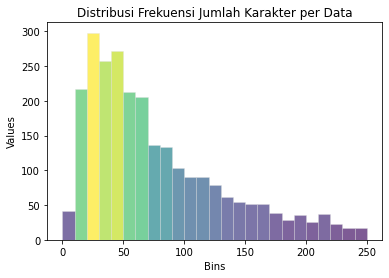

In [ ]:
n, bins, patches = plt.hist(df['clean_tweet'].str.len(), bins=np.arange(0, 260, 10), facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int') 
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

plt.title("Distribusi Frekuensi Jumlah Karakter per Data", fontsize=12)
plt.xlabel('Bins', fontsize=10)
plt.ylabel('Values', fontsize=10)
plt.show()

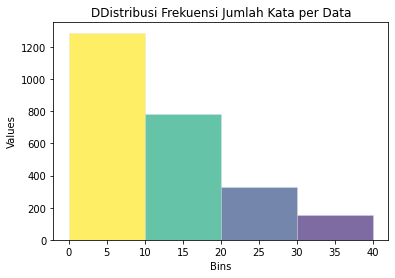

In [ ]:
df['clean_tweet'] = df['clean_tweet'].astype(str)
n, bins, patches = plt.hist(df['clean_tweet'].str.split().map(lambda x: len(x)), bins=np.arange(0,50, 10), facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int') 
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

plt.title("DDistribusi Frekuensi Jumlah Kata per Data", fontsize=12)
plt.xlabel('Bins', fontsize=10)
plt.ylabel('Values', fontsize=10)
plt.show()

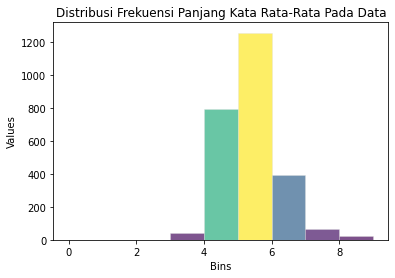

In [ ]:
n, bins, patches = plt.hist(df['clean_tweet'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)), bins=np.arange(0,10, 1), facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int') 
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

plt.title("Distribusi Frekuensi Panjang Kata Rata-Rata Pada Data", fontsize=12)
plt.xlabel('Bins', fontsize=10)
plt.ylabel('Values', fontsize=10)
plt.show()

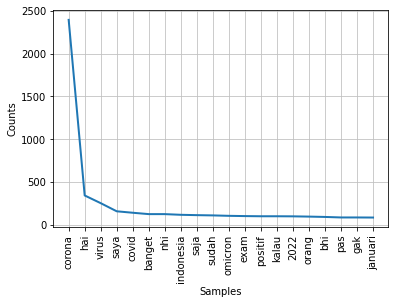

In [ ]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: word_tokenize(str(x)))
tweets = [word for tweet in df['clean_tweet'] for word in tweet]
fqdist = FreqDist(tweets)
fqdist.plot(20,cumulative=False)
plt.show()

In [ ]:
result = pd.Series(nltk.ngrams(tweets, 2)).value_counts()[:15]
result

(virus, corona)         168
(januari, 2022)          60
(corona, corona)         46
(positif, corona)        41
(kena, corona)           34
(corona, virus)          33
(hai, corona)            33
(corona, varian)         32
(corona, indonesia)      32
(varian, omicron)        31
(covid, indonesia)       27
(corona, januari)        25
(indonesia, januari)     23
(pas, corona)            23
(update, corona)         23
dtype: int64

In [ ]:
df['clean_tweet']=df['clean_tweet'].apply(lambda x: clear_stopwords(x))

In [ ]:
df

,Unnamed: 0,Unnamed: 0.1,tweets,retweet_count,retweet_from,created_at,username,user_id,clean_tweet
0,0,0,@republikaonline Bulan2 ini memang musim panca...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,bulan-bulan musim pancaroba musim sakit gitu t...
1,1,1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,musim pancaroba rawan sakit kait corona varian...
2,2,2,Plandemi bagian pemicu proyek politik https://...,0,NaN,2022-01-23,MohSantos2,1333393223620853760,pandemi picu proyek politik
3,3,3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23,piyaaapiyoo,510151538,perintah data covid corona 205 sumbang dki jak...
4,4,4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23,CSAetudiant,749396736540413952,virus corona covid sih pas masuk tubuh segitun...
...,...,...,...,...,...,...,...,...,...
2581,3994,994,@KerenUmwizaOlga Ishyinzwe gukangurira abantu...,0,NaN,2022-01-26,iPromooo,1174592320022482944,ishyinzwe gukangurira abantu kwirinda corona u...
2582,3995,995,Ni corona kapan kelarnya sih ya allah 😭,0,NaN,2022-01-26,tueseungday,580743878,corona kelar sih allah
2583,3997,997,MENYIKAPI ISTRI YANG MANJA (1 menitan)\n\nUsta...,17,muhammadnuzuldz,2022-01-26,ReynaldiOrton,1474367792132485122,sikap istri manja menit ustadz muhammad nuzul ...
2584,3998,998,wadaww corona semua :( cepet sembuh semuanyaa :(,0,NaN,2022-01-26,hitsuzn,1117117428,wadaww corona cepat sembuh


In [ ]:
data_corona = [berita.split() for berita in df["clean_tweet"]]
data_corona

[['bulan-bulan',
  'musim',
  'pancaroba',
  'musim',
  'sakit',
  'gitu',
  'tumben',
  'kait',
  'corona'],
 ['musim',
  'pancaroba',
  'rawan',
  'sakit',
  'kait',
  'corona',
  'varian',
  'kayak',
  'cendol'],
 ['pandemi', 'picu', 'proyek', 'politik'],
 ['perintah',
  'data',
  'covid',
  'corona',
  '205',
  'sumbang',
  'dki',
  'jakarta',
  '825'],
 ['virus',
  'corona',
  'covid',
  'sih',
  'pas',
  'masuk',
  'tubuh',
  'segitunya',
  'bikin',
  'orang',
  'sesak',
  'rebut',
  'oksigen',
  'imun',
  'kerja',
  'thread',
  'lihat',
  'gambar',
  'good',
  'bingung',
  'oke',
  'ceritain'],
 ['pasien',
  'papar',
  'virus',
  'corona',
  'varian',
  'omicron',
  'dki',
  'jakarta',
  'sabtu',
  '2022',
  'capai',
  '313',
  'orang'],
 ['bhid',
  'bhegi',
  'kari',
  'tyare',
  'corona',
  'bjp',
  'vada',
  'gand',
  'bharai',
  'jay'],
 ['sombong',
  'pamer',
  'mentang2',
  'mobil',
  'mahal',
  'foto',
  'jalan',
  'tugas',
  'tepo',
  'sliro',
  'virus',
  'corona',
  'v

In [ ]:
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from numpy import array
import numpy as np
import tqdm

In [ ]:
dictionary = corpora.Dictionary(data_corona)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_corona]

In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(
    random_state=100,
    chunksize=100,
    per_word_topics=True,
    corpus = doc_term_matrix, 
    num_topics=5, 
    id2word = dictionary, 
    passes=50
    )

In [ ]:
from pprint import pprint
pprint(ldamodel.print_topics())

[(0,
  '0.078*"corona" + 0.020*"virus" + 0.012*"banget" + 0.010*"omicron" + '
  '0.009*"covid" + 0.008*"indonesia" + 0.008*"varian" + 0.007*"gak" + '
  '0.007*"vaksin" + 0.006*"pas"'),
 (1,
  '0.048*"corona" + 0.010*"rumah" + 0.009*"kwa" + 0.005*"anjing" + '
  '0.005*"negara" + 0.004*"data" + 0.004*"sdh" + 0.004*"chanjo" + '
  '0.003*"katika" + 0.003*"kazi"'),
 (2,
  '0.039*"corona" + 0.009*"jan" + 0.008*"mein" + 0.006*"sakit" + 0.006*"the" + '
  '0.005*"bhai" + 0.005*"hilang" + 0.005*"angkat" + 0.004*"gaya" + '
  '0.004*"negeri"'),
 (3,
  '0.057*"corona" + 0.031*"hai" + 0.012*"nhi" + 0.011*"2022" + 0.011*"januari" '
  '+ 0.010*"orang" + 0.009*"exam" + 0.007*"positif" + 0.007*"update" + '
  '0.007*"bhi"'),
 (4,
  '0.057*"corona" + 0.012*"deh" + 0.012*"nya" + 0.006*"kaya" + 0.005*"jaga" + '
  '0.005*"kayak" + 0.005*"teman" + 0.005*"konser" + 0.004*"langsung" + '
  '0.004*"kasih"')]


In [ ]:
coherence_model_lda = CoherenceModel(model=ldamodel, texts=data_corona, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3796834764053231


In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_corona, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


  0%|          | 0/540 [01:47<?, ?it/s]
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)

100%|██████████| 540/540 [2:17:28<00:00, 15.27s/it]


In [ ]:
model_lda=pd.read_csv("/content/lda_tuning_results.csv")
model_lda

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.389993
1,75% Corpus,2,0.01,0.31,0.384962
2,75% Corpus,2,0.01,0.61,0.399865
3,75% Corpus,2,0.01,0.9099999999999999,0.422794
4,75% Corpus,2,0.01,symmetric,0.399865
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.505576
536,100% Corpus,10,asymmetric,0.31,0.500141
537,100% Corpus,10,asymmetric,0.61,0.437817
538,100% Corpus,10,asymmetric,0.9099999999999999,0.496889


In [ ]:
df_tuning_result=pd.DataFrame(model_results)
df_tuning_result

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.389993
1,75% Corpus,2,0.01,0.31,0.384962
2,75% Corpus,2,0.01,0.61,0.399865
3,75% Corpus,2,0.01,0.91,0.422794
4,75% Corpus,2,0.01,symmetric,0.399865
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.505576
536,100% Corpus,10,asymmetric,0.31,0.500141
537,100% Corpus,10,asymmetric,0.61,0.437817
538,100% Corpus,10,asymmetric,0.91,0.496889


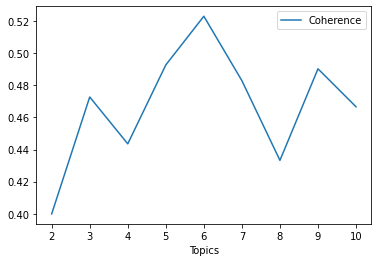

In [ ]:
df_plot = df_tuning_result[(df_tuning_result.Alpha == 0.01) & (df_tuning_result.Beta == 0.61) & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot.plot(x='Topics', y = "Coherence", kind="line")

In [ ]:
df_plot_2 = df_tuning_result[(df_tuning_result.Topics == 6) & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot_2.sort_values(by="Coherence", ascending=False)
 

,Validation_Set,Topics,Alpha,Beta,Coherence
403,100% Corpus,6,0.61,0.91,0.543177
401,100% Corpus,6,0.61,0.31,0.538491
413,100% Corpus,6,symmetric,0.91,0.536024
418,100% Corpus,6,asymmetric,0.91,0.526366
408,100% Corpus,6,0.91,0.91,0.525466
398,100% Corpus,6,0.31,0.91,0.525051
392,100% Corpus,6,0.01,0.61,0.523060
397,100% Corpus,6,0.31,0.61,0.515843
412,100% Corpus,6,symmetric,0.61,0.514285
415,100% Corpus,6,asymmetric,0.01,0.512123


In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.61,
                                           eta=0.91)
 
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.068*"corona" + 0.010*"virus" + 0.006*"indonesia" + 0.006*"banget" + '
  '0.005*"covid" + 0.005*"omicron" + 0.005*"2022" + 0.005*"januari" + '
  '0.004*"positif" + 0.004*"orang"'),
 (1,
  '0.006*"corona" + 0.005*"kwa" + 0.002*"chanjo" + 0.002*"kazi" + '
  '0.002*"katika" + 0.002*"afya" + 0.001*"serikali" + 0.001*"watu" + '
  '0.001*"maambukizi" + 0.001*"had"'),
 (2,
  '0.001*"kumaraswamy" + 0.001*"dundra" + 0.001*"reply" + 0.001*"and" + '
  '0.001*"enna" + 0.001*"song" + 0.001*"sarah" + 0.001*"dhan" + 0.001*"oru" + '
  '0.001*"than"'),
 (3,
  '0.036*"corona" + 0.018*"hai" + 0.007*"nhi" + 0.005*"exam" + 0.004*"bhi" + '
  '0.003*"jan" + 0.003*"aur" + 0.003*"nahi" + 0.003*"kya" + 0.003*"hua"'),
 (4,
  '0.001*"hada" + 0.001*"kelurahan" + 0.001*"dangerous" + 0.001*"hanta" + '
  '0.001*"saima" + 0.001*"nimra" + 0.001*"sidra" + 0.001*"saba" + '
  '0.001*"ayesha" + 0.001*"aqsa"'),
 (5,
  '0.001*"ghadi" + 0.001*"fih" + 0.001*"rah" + 0.001*"ahok" + 0.001*"kant" + '
  '0.001*"dyal" + 0.0

In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 237 kB/s 
     |████████████████████████████████| 11.3 MB 31.8 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=7302985fad8e6fcf6cf8e2ed8f4dec254befab546b60b6f5777f9768858b35a3
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take int

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## Machine Learning

In [5]:
df.drop(["Unnamed: 0","Unnamed: 0.1"],axis=1,inplace=True)
df

,tweets,retweet_count,retweet_from,created_at,username,user_id,clean_tweet
0,@republikaonline Bulan2 ini memang musim panca...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,bulan-bulan musim pancaroba musim sakit gitu t...
1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,musim pancaroba rawan sakit kait corona varian...
2,Plandemi bagian pemicu proyek politik https://...,0,NaN,2022-01-23,MohSantos2,1333393223620853760,pandemi picu proyek politik
3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23,piyaaapiyoo,510151538,perintah umum data covid corona 205 sumbang dk...
4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23,CSAetudiant,749396736540413952,virus corona sebab covid sedang apa saja sih p...
...,...,...,...,...,...,...,...
2581,@KerenUmwizaOlga Ishyinzwe gukangurira abantu...,0,NaN,2022-01-26,iPromooo,1174592320022482944,ishyinzwe gukangurira abantu kwirinda corona u...
2582,Ni corona kapan kelarnya sih ya allah 😭,0,NaN,2022-01-26,tueseungday,580743878,corona kelar sih allah
2583,MENYIKAPI ISTRI YANG MANJA (1 menitan)\n\nUsta...,17,muhammadnuzuldz,2022-01-26,ReynaldiOrton,1474367792132485122,sikap istri manja menit ustadz muhammad nuzul ...
2584,wadaww corona semua :( cepet sembuh semuanyaa :(,0,NaN,2022-01-26,hitsuzn,1117117428,wadaww corona cepat sembuh semuanya


In [6]:
df

,tweets,retweet_count,retweet_from,created_at,username,user_id,clean_tweet
0,@republikaonline Bulan2 ini memang musim panca...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,bulan-bulan musim pancaroba musim sakit gitu t...
1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,musim pancaroba rawan sakit kait corona varian...
2,Plandemi bagian pemicu proyek politik https://...,0,NaN,2022-01-23,MohSantos2,1333393223620853760,pandemi picu proyek politik
3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23,piyaaapiyoo,510151538,perintah umum data covid corona 205 sumbang dk...
4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23,CSAetudiant,749396736540413952,virus corona sebab covid sedang apa saja sih p...
...,...,...,...,...,...,...,...
2581,@KerenUmwizaOlga Ishyinzwe gukangurira abantu...,0,NaN,2022-01-26,iPromooo,1174592320022482944,ishyinzwe gukangurira abantu kwirinda corona u...
2582,Ni corona kapan kelarnya sih ya allah 😭,0,NaN,2022-01-26,tueseungday,580743878,corona kelar sih allah
2583,MENYIKAPI ISTRI YANG MANJA (1 menitan)\n\nUsta...,17,muhammadnuzuldz,2022-01-26,ReynaldiOrton,1474367792132485122,sikap istri manja menit ustadz muhammad nuzul ...
2584,wadaww corona semua :( cepet sembuh semuanyaa :(,0,NaN,2022-01-26,hitsuzn,1117117428,wadaww corona cepat sembuh semuanya


In [7]:
df['clean_tweet'] = df['clean_tweet'].astype(str)

In [9]:
pos_list= open("/content/kata_positif.txt","r")
pos_kata = pos_list.readlines()
neg_list= open("/content/kata_negatif.txt","r")
neg_kata = neg_list.readlines()  
items= df['clean_tweet'].tolist()

In [12]:
pos_kata=list(map(lambda x: case_folding(x),pos_kata)) 
neg_kata=list(map(lambda x: case_folding(x),neg_kata)) 

In [13]:
#Lakukan Sentiment Analysis 
#masukkan hasilnya pada dataframe dengan nama kolom "sentiment"


list_anti = ['tidak','lawan','anti', 'belum', 'belom', 'tdk', 'jangan', 'gak', 'enggak', 'bukan', 'sulit', 'tak', 'sblm']
for item in items:
    print(item.strip())
    tweets = item.strip().split() #tokenization
    # print(tweets)
    
    count_p = 0 #nilai positif
    count_n = 0 #nilai negatif
    
    for tweet in tweets:
        for kata_pos in pos_kata:
            if kata_pos.strip().lower() == tweet.lower():
                if items[items.index(item)-1] in list_anti:
                    print(items[items.index(item)-1], kata_pos, ['negatif'])
                    count_n += 1
                else:
                    print(kata_pos, ['positif'])
                    count_p += 1
        for kata_neg in neg_kata:
            if kata_neg.strip().lower() == tweet.lower():
                if items[items.index(item)-1] in list_anti:
                    print(items[items.index(item)-1], kata_neg, ['positif'])
                    count_p += 1
                else:
                    print(kata_neg, ['negatif'])
                    count_n += 1
    
    print ("positif: "+str(count_p))
    print ("negatif: "+str(count_n))

Output streaming akan dipotong hingga 5000 baris terakhir.
 ['negatif']
ribet
 ['negatif']
positif: 0
negatif: 2
mecima alhamdulillah tahu beneran sampean corona hilang
alhamdulillah
 ['positif']
tahu
 ['positif']
hilang
 ['negatif']
hilang
 ['negatif']
positif: 2
negatif: 2
tips kendara wabah corona varian omicron yuk simak
wabah
 ['negatif']
positif: 0
negatif: 1
thotru romba athigama iruku mudiyala athu than kadavul than kapathanum salipa iruku intha corona performance
positif: 0
negatif: 0
iyasih tidak bisa prediksi yakk apalg ngambilnya tanggal tanggal natal gin moga saja sih corona deh tidak ada uang
bisa
 ['positif']
positif: 1
negatif: 0
tunakujuza
positif: 0
negatif: 0
corona hilang ngonser2 sih mengurus bayi
hilang
 ['negatif']
hilang
 ['negatif']
positif: 0
negatif: 2
arshad iqbal kamran akmal corona positive aya hai nahi
positif: 0
negatif: 0
kalau corona libur skolahku
positif: 0
negatif: 0
se3iba corona bac algerie rayha rabi yjib khir
positif: 0
negatif: 0
positif banget

In [14]:
hasil = []
list_anti = ['tidak','lawan','anti', 'belum', 'belom', 'tdk', 'jangan', 'gak', 'enggak', 'bukan', 'sulit', 'tak', 'sblm']

for item in items:
    print(item.strip())
    tweets = item.strip().split() #tokenization
    # print(tweets)
    
    count_p = 0 #nilai positif
    count_n = 0 #nilai negatif
    
    for tweet in tweets:
        for kata_pos in pos_kata:
            if kata_pos.strip().lower() == tweet.lower():
                if items[items.index(item)-1] in list_anti:
                    print(items[items.index(item)-1], kata_pos, ['negatif'])
                    count_n += 1
                else:
                    print(kata_pos, ['positif'])
                    count_p += 1
        for kata_neg in neg_kata:
            if kata_neg.strip().lower() == tweet.lower():
                if items[items.index(item)-1] in list_anti:
                    print(items[items.index(item)-1], kata_neg, ['positif'])
                    count_p += 1
                else:
                    print(kata_neg, ['negatif'])
                    count_n += 1
    
    print ("positif: "+str(count_p))
    print ("negatif: "+str(count_n))
    hasil.append(count_p - count_n)
    # print ("-----------------------------------------------------")
    
print ("Nilai rata-rata: "+str(np.mean(hasil)))
print ("Standar deviasi: "+str(np.std(hasil)))

Output streaming akan dipotong hingga 5000 baris terakhir.
 ['negatif']
positif: 0
negatif: 2
mecima alhamdulillah tahu beneran sampean corona hilang
alhamdulillah
 ['positif']
tahu
 ['positif']
hilang
 ['negatif']
hilang
 ['negatif']
positif: 2
negatif: 2
tips kendara wabah corona varian omicron yuk simak
wabah
 ['negatif']
positif: 0
negatif: 1
thotru romba athigama iruku mudiyala athu than kadavul than kapathanum salipa iruku intha corona performance
positif: 0
negatif: 0
iyasih tidak bisa prediksi yakk apalg ngambilnya tanggal tanggal natal gin moga saja sih corona deh tidak ada uang
bisa
 ['positif']
positif: 1
negatif: 0
tunakujuza
positif: 0
negatif: 0
corona hilang ngonser2 sih mengurus bayi
hilang
 ['negatif']
hilang
 ['negatif']
positif: 0
negatif: 2
arshad iqbal kamran akmal corona positive aya hai nahi
positif: 0
negatif: 0
kalau corona libur skolahku
positif: 0
negatif: 0
se3iba corona bac algerie rayha rabi yjib khir
positif: 0
negatif: 0
positif banget berita moga cepat 

In [19]:
df['sentiment']=hasil

In [22]:
df

,tweets,retweet_count,retweet_from,created_at,username,user_id,clean_tweet,sentiment
0,@republikaonline Bulan2 ini memang musim panca...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,bulan-bulan musim pancaroba musim sakit gitu t...,-1
1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,musim pancaroba rawan sakit kait corona varian...,-3
2,Plandemi bagian pemicu proyek politik https://...,0,NaN,2022-01-23,MohSantos2,1333393223620853760,pandemi picu proyek politik,-1
3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23,piyaaapiyoo,510151538,perintah umum data covid corona 205 sumbang dk...,0
4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23,CSAetudiant,749396736540413952,virus corona sebab covid sedang apa saja sih p...,-2
...,...,...,...,...,...,...,...,...
2581,@KerenUmwizaOlga Ishyinzwe gukangurira abantu...,0,NaN,2022-01-26,iPromooo,1174592320022482944,ishyinzwe gukangurira abantu kwirinda corona u...,0
2582,Ni corona kapan kelarnya sih ya allah 😭,0,NaN,2022-01-26,tueseungday,580743878,corona kelar sih allah,0
2583,MENYIKAPI ISTRI YANG MANJA (1 menitan)\n\nUsta...,17,muhammadnuzuldz,2022-01-26,ReynaldiOrton,1474367792132485122,sikap istri manja menit ustadz muhammad nuzul ...,0
2584,wadaww corona semua :( cepet sembuh semuanyaa :(,0,NaN,2022-01-26,hitsuzn,1117117428,wadaww corona cepat sembuh semuanya,1


In [23]:
df['sentiment'].mask(df['sentiment'] >0 ,2, inplace=True)
df['sentiment'].mask(df['sentiment'] == 0 ,1, inplace=True)
df['sentiment'].mask(df['sentiment'] <0 ,0, inplace=True)

In [24]:
df

,tweets,retweet_count,retweet_from,created_at,username,user_id,clean_tweet,sentiment
0,@republikaonline Bulan2 ini memang musim panca...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,bulan-bulan musim pancaroba musim sakit gitu t...,0
1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,musim pancaroba rawan sakit kait corona varian...,0
2,Plandemi bagian pemicu proyek politik https://...,0,NaN,2022-01-23,MohSantos2,1333393223620853760,pandemi picu proyek politik,0
3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23,piyaaapiyoo,510151538,perintah umum data covid corona 205 sumbang dk...,1
4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23,CSAetudiant,749396736540413952,virus corona sebab covid sedang apa saja sih p...,0
...,...,...,...,...,...,...,...,...
2581,@KerenUmwizaOlga Ishyinzwe gukangurira abantu...,0,NaN,2022-01-26,iPromooo,1174592320022482944,ishyinzwe gukangurira abantu kwirinda corona u...,1
2582,Ni corona kapan kelarnya sih ya allah 😭,0,NaN,2022-01-26,tueseungday,580743878,corona kelar sih allah,1
2583,MENYIKAPI ISTRI YANG MANJA (1 menitan)\n\nUsta...,17,muhammadnuzuldz,2022-01-26,ReynaldiOrton,1474367792132485122,sikap istri manja menit ustadz muhammad nuzul ...,1
2584,wadaww corona semua :( cepet sembuh semuanyaa :(,0,NaN,2022-01-26,hitsuzn,1117117428,wadaww corona cepat sembuh semuanya,2


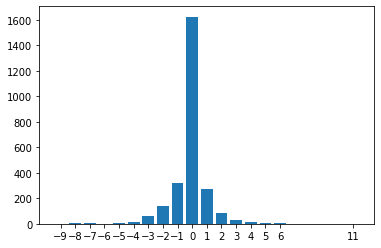

In [25]:
labels, counts = np.unique(hasil, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

In [26]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
 

In [27]:
vectorizer = TfidfVectorizer (max_features=2500)

model_g = GaussianNB()
 

In [28]:
v_data = vectorizer.fit_transform(df['clean_tweet']).toarray()
vectorizer.fit_transform(df['clean_tweet'])

<2586x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 19861 stored elements in Compressed Sparse Row format>

In [29]:
X_train, X_test, y_train, y_test = train_test_split(v_data, df['sentiment'], test_size=0.2, random_state=18)

model_g.fit(X_train,y_train)

GaussianNB()

In [30]:
y_preds = model_g.predict(X_test)

print('nilai akurasinya adalah ',accuracy_score(y_test, y_preds))

 

nilai akurasinya adalah  0.5173745173745173


## Word Cloud

In [86]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
lst = set(stopwords.words('english'))
lst = [x.strip() for x in lst] 
# tokenize helper function
def text_process(raw_text):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in lst]

# -------------------------------------------

# tokenize message column and create a column for tokens
df['tokens'] = df['clean_tweet'].apply(text_process) # tokenize style 1
df_terbaru = df[['tweets','tokens']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
all_words = []
for line in df_terbaru['tokens']: 
    all_words.extend(line)  
# create a word frequency dictionary
wordfreq = Counter(all_words)
wordfreq.most_common(10)

[('corona', 2394),
 ('hai', 342),
 ('virus', 252),
 ('saya', 157),
 ('covid', 140),
 ('banget', 124),
 ('nhi', 124),
 ('indonesia', 116),
 ('saja', 112),
 ('sudah', 109)]

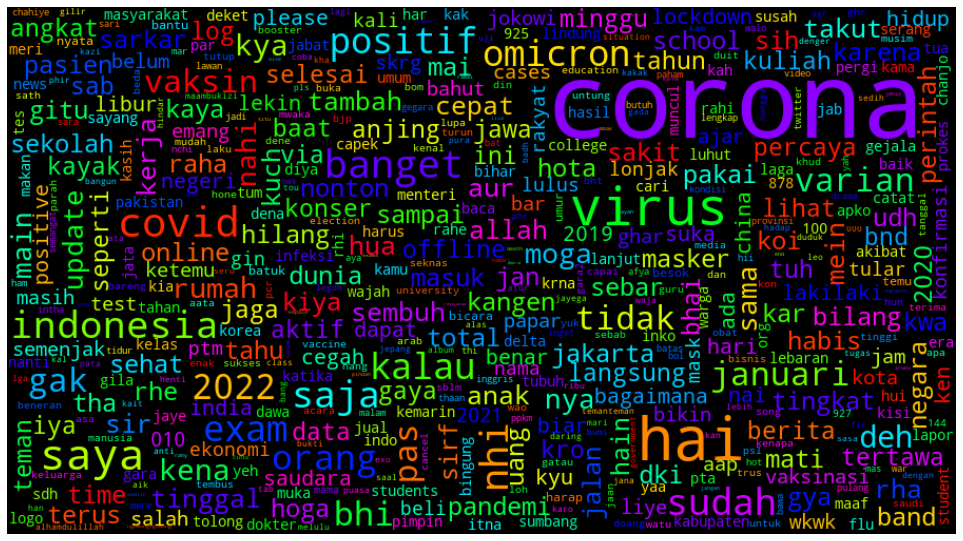

In [88]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='gist_rainbow',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [89]:
# SNA
import networkx as nx
from networkx.readwrite import json_graph
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot, plot
init_notebook_mode(connected=True)
import plotly.figure_factory as ff

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



In [92]:
df

,tweets,retweet_count,retweet_from,created_at,username,user_id,clean_tweet,tokens,sentiment
0,@republikaonline Bulan2 ini memang musim panca...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,bulan-bulan musim pancaroba musim sakit gitu t...,"[bulanbulan, musim, pancaroba, musim, sakit, g...",-1
1,@LaporCovid Musim pancaroba ini memang lagi ra...,0,NaN,2022-01-23,cakmas12345,1176063840661848064,musim pancaroba rawan sakit kait corona varian...,"[musim, pancaroba, rawan, sakit, kait, corona,...",-3
2,Plandemi bagian pemicu proyek politik https://...,0,NaN,2022-01-23,MohSantos2,1333393223620853760,pandemi picu proyek politik,"[pandemi, picu, proyek, politik]",-1
3,Pemerintah kembali mengumumkan data kasus COVI...,25,detikcom,2022-01-23,piyaaapiyoo,510151538,perintah umum data covid corona 205 sumbang dk...,"[perintah, umum, data, covid, corona, 205, sum...",0
4,Sebenarnya virus corona penyebab COVID-19 ngap...,25662,afrkml,2022-01-23,CSAetudiant,749396736540413952,virus corona sebab covid sedang apa saja sih p...,"[virus, corona, sebab, covid, sedang, apa, saj...",-2
...,...,...,...,...,...,...,...,...,...
2581,@KerenUmwizaOlga Ishyinzwe gukangurira abantu...,0,NaN,2022-01-26,iPromooo,1174592320022482944,ishyinzwe gukangurira abantu kwirinda corona u...,"[ishyinzwe, gukangurira, abantu, kwirinda, cor...",0
2582,Ni corona kapan kelarnya sih ya allah 😭,0,NaN,2022-01-26,tueseungday,580743878,corona kelar sih allah,"[corona, kelar, sih, allah]",0
2583,MENYIKAPI ISTRI YANG MANJA (1 menitan)\n\nUsta...,17,muhammadnuzuldz,2022-01-26,ReynaldiOrton,1474367792132485122,sikap istri manja menit ustadz muhammad nuzul ...,"[sikap, istri, manja, menit, ustadz, muhammad,...",0
2584,wadaww corona semua :( cepet sembuh semuanyaa :(,0,NaN,2022-01-26,hitsuzn,1117117428,wadaww corona cepat sembuh semuanya,"[wadaww, corona, cepat, sembuh, semuanya]",1


## Social Network Analysis

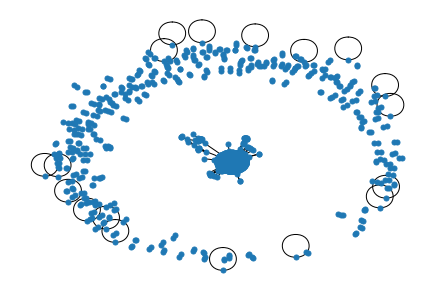

In [93]:
# Netwrokx
net = nx.from_pandas_edgelist(df, source="retweet_from", target="username")
# Plot it
nx.draw(net, with_labels=False, node_size=25)
plt.show()

In [94]:
G = nx.convert_node_labels_to_integers(net, first_label=0, ordering='default', label_attribute=None)
pos=nx.fruchterman_reingold_layout(G)
#create labels
poslabs=nx.fruchterman_reingold_layout(net)
labels=list(poslabs) + list(' : ')
#create edges
Xe=[]
Ye=[]
for e in G.edges():
    Xe.extend([pos[e[0]][0], pos[e[1]][0], None])
    Ye.extend([pos[e[0]][1], pos[e[1]][1], None])
trace_edges=dict(type='scatter',
                 mode='lines',
                 x=Xe,
                 y=Ye,
                 line=dict(width=1, color='rgb(25,25,25)'),
                 hoverinfo='none' 
                )

#create nodes
Xn=[pos[k][0] for k in range(len(pos))]
Yn=[pos[k][1] for k in range(len(pos))]
trace_nodes=dict(type='scatter',
                 x=Xn, 
                 y=Yn,
                 mode='markers',
                 marker=dict(showscale=True,size=5,color=[],colorscale='Rainbow',reversescale=True,colorbar=dict(
                    thickness=15,
                    title='Node Connections',
                    xanchor='left',
                    titleside='right')),
                 text=labels,
                 hoverinfo='text')

#scale color by size
for node, adjacencies in enumerate(G.adjacency()):
    trace_nodes['marker']['color']+=tuple([len(adjacencies[1])])
#plot
axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )
layout=dict(title= 'Social Network Analysis',  
            font= dict(family='Balto'),
            width=1000,
            height=1000,
            autosize=False,
            showlegend=False,
            xaxis=axis,
            yaxis=axis,
            margin=dict(l=40,r=40,b=85,t=100,pad=0,
            ),
            hovermode='closest',
#     plot_bgcolor='#000000',           
    )
fig = dict(data=[trace_edges,trace_nodes], layout=layout)
#run plot
iplot(fig)
plot(fig, filename='myplot.html')

'myplot.html'

## Kesimpulan

Rata-rata perbincangan twitter pada bulan januari ini menilai dampak corona sebagai suatu sentimen yang negatif.Jika kita lihat dari topik atau wordcloud maka dapat disimpulakn bahwa banyak orang yang terkena dampak varian corona omicron pada januari 2022 ini.lalu persebaran cuitan berita mengenai corona ini rata-rata juga merupakan kalimat opini apabial kita lihat dari banyaknya jumlah kata.Banyak juga perdebatan mengenai sekolah yang akan offline ini mengingat bahwa varian omicron yang sangat tinggi.Jika kita lihat dari sna maka dapat disimpulkan bahwa kebanyakn post di tweet oleh berita lalu di retwwet oleh satu orang dan kebanyak orang mertweet dari hasil tanggapan orang yang pertama kali meretwwet dari berita tersebut